<img src="https://upload.wikimedia.org/wikipedia/fr/b/bf/Universit%C3%A9_Laval_logo_et_texte.svg" width=200 align="right"><br>
<b> Projet de conception en génie physique GPH-3110 </b><br>
<b> Département de physique, de génie physique et d'optique </b><br>
<b> Hiver 2023 </b><br>
<b> Université Laval </b><br>

<center><h1>Thermistor voltage - temperature simulation</h2></center>

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = "svg"

import numpy as np
from pandas import read_excel
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
plt.rcParams.update(
    {
        "lines.linewidth": 1.5,
        "axes.labelsize": "x-large",
        "axes.labelpad": 10,
        "axes.grid": True,
        "axes.grid.which": "both",
        "grid.linestyle": ":",
        "grid.color": "k",
        "grid.alpha": 0.5,
        "xtick.minor.visible": True,
        "xtick.direction": "in",
        "xtick.major.size": 10,
        "xtick.major.width": 1,
        "xtick.minor.size": 5,
        "xtick.minor.width": 0.5,
        "ytick.minor.visible": True,
        "ytick.direction": "in",
        "ytick.major.size": 10,
        "ytick.major.width": 1,
        "ytick.minor.size": 5,
        "ytick.minor.width": 0.5,
    }
)

## Steinhart-Hart equation

The Steinhart-Hart equation is a model of the resistance $R$ of a semiconductor at different temperatures $T$. The equation is
\begin{gather}
    \frac{1}{T}=A+B\ln{R}+C\ln(R)^2+D(\ln{R})^3 \ ,
\end{gather}

### Find $A$, $B$, $C$ and $D$ with curve fit

#### Extract thermistor data from datasheet

In [3]:
data = read_excel(
    "NDBG104F3435B2F.xlsx",
    header=3,
    dtype=float,
    names=["temp", "res"],
)
data = data.to_numpy()
temp = data[:,0] + 273.15   # convert temperature to absolute temperature
res = data[:,1]*1000        # resistance values in kOhm

#### Define Steinhart-Hart equations

In [4]:
def steinhart_hart(R: float, A: float, B: float, C: float, D: float) -> float:
    """Calculate thermistor temperature with Steinhart-Hart equation.

    Parameters:
    -----------
        R : float
            Thermistor resistance.
        A : float
            Steinhart-Hart "A" coefficient.
        B float
            Steinhart-Hart "B" coefficient.
        C float
            Steinhart-Hart "C" coefficient.
        D float
            Steinhart-Hart "D" coefficient.

    Returns:
    --------
        T : float
            Thermistor temperature in kelvin.

    """
    T = A + B*np.log(R) + C*np.log(R)**2 + D*np.log(R)**3
    T = T**-1
    return T

#### Curve fit data

In [5]:
p0 = [1e-4, 1e-4, 1e-6, 1e-7]  # Guess initial values
popt, _ = curve_fit(steinhart_hart, res, temp, p0=p0, maxfev=5000)
print("Coeffs: {}".format(popt))

Coeffs: [ 1.16462122e-03  1.68263967e-04  8.40211371e-06 -1.00119948e-07]


#### Plot fitted data

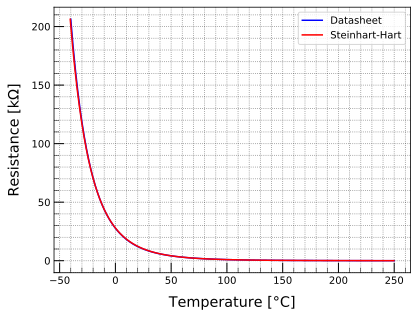

In [6]:
plt.plot(temp-273.15, res*1e-3, "b", label="Datasheet")
plt.plot(steinhart_hart(res, *popt)-273.15, res*1e-3, "r", label="Steinhart-Hart")
# plt.plot(res, np.abs(np.subtract(temp, steinhart_hart(res, *popt))), "g", label="error values")
plt.ylabel("Resistance [k$\Omega$]")
plt.xlabel("Temperature [$\degree$C]")
plt.legend()
plt.show()

## Weatstone bridge
<center><img src="https://upload.wikimedia.org/wikipedia/commons/9/93/Wheatstonebridge.svg" width=300></center>

The thermistor resistance $R_x$ is given by
\begin{gather}
    R_x = R + \Delta R \ , \tag{2}
\end{gather}

where $R$ is the nominal thermistor resistance at 25&deg;C and $\Delta R$ is the resistance change of the thermistor. From Kirchhoff's laws and the fact that $R_1=R_2=R_3=R$, we have
\begin{align}
    V_G &= \frac{V_{out}}{G} = B - D = V_s\left[\frac{R+\Delta R}{2R+\Delta R}-\frac{1}{2}\right] \ , \tag{3} \\[0.25cm]
    &= \frac{\Delta R}{4R+2\Delta R}V_s \ , \tag{4} \\[0.25cm]
    \Delta R &= -\frac{4RV_{out}}{2V_{out}-GV_s} \ , \tag{5} \\[0.25cm]
    R_x &= R+\Delta R = R\left(1 - \frac{4V_{out}}{2V_{out}-GV_s}\right) \ , \tag{6}
\end{align}

where $V_s$ is the supply voltage, $V_{out}$ is the amplifier output voltage and $G$ is the amplifier gain.

In [7]:
def sim(dV: float, G: float | int = 1, R: int = 10e3, Vs: float = 3.3) -> float:
    """Calculate thermistor temperature based on amplifier's output voltage.

    Parameters:
    -----------
        dV : float
            _description_
        G : float or int, optional
            Amplifier gain. Defaults to 1.
        R : int, optional
            Thermistor nominal resistance at 25°C. Defaults to 10 000.
        Vs : float, optional
            Weatstone bridge supply voltage in volts. Defaults to 3.3.

    Returns:
    --------
        T : float
            Thermistor temperature in °C.

    """
    Rx = R*(1 - (4*dV) / (2*dV - G*Vs))
    T = steinhart_hart(Rx, *popt) - 273.15
    return T

#### Simulation results

In [8]:
s1 = sim(0.18)
s1

19.729888995456918